import set up

#Binary Classification
#3D RESNET with CBAM for MRI Classification in PyTorch

0 → CN (Not Alzheimer's)

1 → AD (Alzheimer's)

**Output**

training acc :39.06%

Val acc : 40.89%



In [1]:
!pip install nibabel scipy

import os
import random
import torch
import numpy as np
import nibabel as nib
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import seaborn as sns
from scipy.ndimage import zoom
from torch.amp import autocast, GradScaler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Data Agumentation

In [2]:
def augment_volume(volume):
    if random.random() > 0.5:
        volume = np.flip(volume, axis=0)
    if random.random() > 0.5:
        volume = np.flip(volume, axis=1)
    if random.random() > 0.5:
        volume = np.flip(volume, axis=2)
    k = random.choice([0,1,2,3])
    axis = random.choice([(0,1),(1,2),(0,2)])
    volume = np.rot90(volume, k=k, axes=axis)
    if random.random() > 0.5:
        noise = np.random.normal(0, 0.02, volume.shape)
        volume = volume + noise
    if random.random() > 0.5:
        scale = random.uniform(0.9, 1.1)
        volume = volume * scale
    volume = np.clip(volume, 0, 1)
    return volume


MRI dataset

In [3]:
class MRI3DDataset(Dataset):
    def __init__(self, samples, target_shape=(128, 128, 128), augment=False):
        self.samples = samples
        self.target_shape = target_shape
        self.augment = augment

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        nii_path, label = self.samples[idx]
        img = nib.load(nii_path).get_fdata()
        img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)
        img = self.resize_volume(img, self.target_shape)
        if self.augment:
            img = augment_volume(img)
        img = img[np.newaxis, ...].astype(np.float32)
        return torch.tensor(img), label

    def resize_volume(self, volume, target_shape):
        depth, height, width = volume.shape
        target_depth, target_height, target_width = target_shape
        depth_factor = target_depth / depth
        height_factor = target_height / height
        width_factor = target_width / width
        return zoom(volume, (depth_factor, height_factor, width_factor), order=1)


data preparation


In [4]:
root_dir = '/kaggle/input/dataset-nifiti2/DATASET_NIFTI2'
class_names = ['AD', 'CN', 'MCI']  # Change as needed
class_map = {'CN': 0, 'AD': 1, 'MCI': 2}
random.seed(42)

train_samples, val_samples, test_samples = [], [], []

for cls in class_names:
    class_dir = os.path.join(root_dir, cls)
    if not os.path.exists(class_dir): continue
    nii_files = [f for f in os.listdir(class_dir) if f.endswith(('.nii', '.nii.gz'))]
    random.shuffle(nii_files)
    n_total = len(nii_files)
    n_train = int(0.7 * n_total)
    n_val = int(0.15 * n_total)
    for file_list, sample_list in zip([nii_files[:n_train],
                                       nii_files[n_train:n_train+n_val],
                                       nii_files[n_train+n_val:]],
                                      [train_samples, val_samples, test_samples]):
        for nii_file in file_list:
            nii_path = os.path.join(class_dir, nii_file)
            sample_list.append((nii_path, class_map[cls]))

batch_size = 2
target_shape = (128, 128, 128)
train_dataset = MRI3DDataset(train_samples, target_shape, augment=True)
val_dataset = MRI3DDataset(val_samples, target_shape, augment=False)
test_dataset = MRI3DDataset(test_samples, target_shape, augment=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

3D VGG Model

In [5]:
class VGG3D(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv3d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),
            nn.Conv3d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(2),

            nn.Conv3d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            nn.Conv3d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(2),

            nn.Conv3d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(inplace=True),
            nn.Conv3d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(2),

            nn.Conv3d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm3d(256),
            nn.ReLU(inplace=True),
            nn.Conv3d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm3d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool3d(2),
        )
        self.avgpool = nn.AdaptiveAvgPool3d((2, 2, 2))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 2 * 2 * 2, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x

model = VGG3D(num_classes=len(class_names))
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)
model = model.to(device)


Using 2 GPUs!


Training Loop

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
scaler = GradScaler("cuda")
num_epochs = 10
best_val_acc = 0

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for i, (volumes, labels) in enumerate(train_loader):
        volumes, labels = volumes.to(device), labels.to(device)
        optimizer.zero_grad()
        with autocast("cuda", dtype=torch.float16):
            outputs = model(volumes)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item() * volumes.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if i % 5 == 0:
            print(f"Epoch {epoch+1}, Batch {i+1}/{len(train_loader)}, Loss: {loss.item():.4f}")
    train_acc = 100 * correct / total

    # Validation
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for volumes, labels in val_loader:
            volumes, labels = volumes.to(device), labels.to(device)
            with autocast("cuda", dtype=torch.float16):
                outputs = model(volumes)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    val_acc = 100 * val_correct / val_total

    torch.save(model.state_dict(), '/kaggle/working/best_model_vgg3d.pth')
    print(f"[Checkpoint saved after epoch {epoch+1}]")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), '/kaggle/working/best_model_vgg3d_bestval.pth')
        print(f"[Best model updated at epoch {epoch+1}]")

    print(f"Epoch {epoch+1}/{num_epochs}: Loss={running_loss/len(train_loader.dataset):.4f} "
          f"Train Acc={train_acc:.2f}% Val Acc={val_acc:.2f}%")


Epoch 1, Batch 1/681, Loss: 1.2314
Epoch 1, Batch 6/681, Loss: 0.8975
Epoch 1, Batch 11/681, Loss: 1.1018
Epoch 1, Batch 16/681, Loss: 1.2468
Epoch 1, Batch 21/681, Loss: 1.3276
Epoch 1, Batch 26/681, Loss: 1.1895
Epoch 1, Batch 31/681, Loss: 1.5073
Epoch 1, Batch 36/681, Loss: 1.3281
Epoch 1, Batch 41/681, Loss: 1.0203
Epoch 1, Batch 46/681, Loss: 0.7969
Epoch 1, Batch 51/681, Loss: 0.8328
Epoch 1, Batch 56/681, Loss: 0.8397
Epoch 1, Batch 61/681, Loss: 0.9380
Epoch 1, Batch 66/681, Loss: 0.9780
Epoch 1, Batch 71/681, Loss: 0.6907
Epoch 1, Batch 76/681, Loss: 1.1155
Epoch 1, Batch 81/681, Loss: 1.6812
Epoch 1, Batch 86/681, Loss: 0.9724
Epoch 1, Batch 91/681, Loss: 1.7417
Epoch 1, Batch 96/681, Loss: 1.2812
Epoch 1, Batch 101/681, Loss: 1.5776
Epoch 1, Batch 106/681, Loss: 1.6646
Epoch 1, Batch 111/681, Loss: 1.4995
Epoch 1, Batch 116/681, Loss: 1.0190
Epoch 1, Batch 121/681, Loss: 1.0911
Epoch 1, Batch 126/681, Loss: 1.3262
Epoch 1, Batch 131/681, Loss: 0.8650
Epoch 1, Batch 136/681,

Evaluation & Visualization

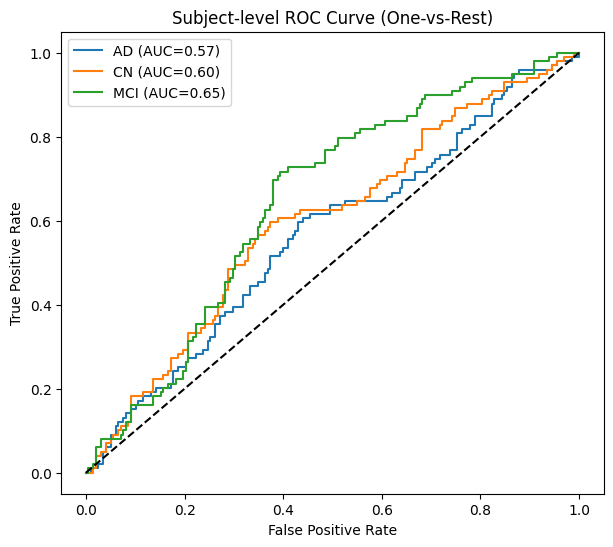

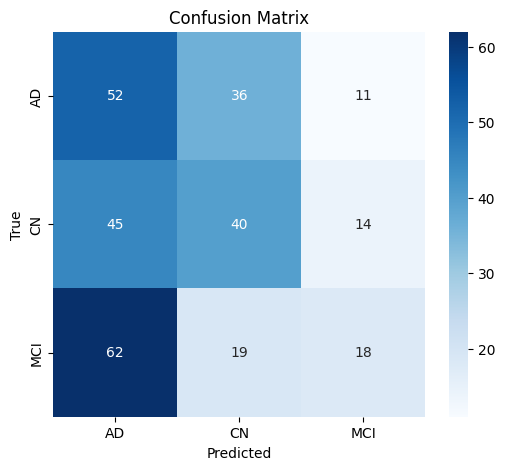

              precision    recall  f1-score   support

          AD       0.33      0.53      0.40        99
          CN       0.42      0.40      0.41        99
         MCI       0.42      0.18      0.25        99

    accuracy                           0.37       297
   macro avg       0.39      0.37      0.36       297
weighted avg       0.39      0.37      0.36       297



In [7]:
model.load_state_dict(torch.load('/kaggle/working/best_model_vgg3d_bestval.pth'))
model.eval()
all_preds, all_targets, all_probs = [], [], []
with torch.no_grad():
    for volumes, labels in test_loader:
        volumes = volumes.to(device)
        outputs = model(volumes)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(labels.numpy())
        all_probs.extend(probs)

all_targets = np.array(all_targets)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

# Multiclass ROC (one-vs-rest)
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve((all_targets == i).astype(int), all_probs[:, i])
    roc_auc[i] = roc_auc_score((all_targets == i).astype(int), all_probs[:, i])
plt.figure(figsize=(7,6))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC={roc_auc[i]:.2f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Subject-level ROC Curve (One-vs-Rest)")
plt.legend()
plt.show()

# Confusion matrix and report
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
print(classification_report(all_targets, all_preds, target_names=class_names))


Systematic Prediction Visualization

In [8]:
def visualize_predictions(dataset, model, device, class_names, num_subjects=8):
    model.eval()
    fig, axes = plt.subplots(num_subjects, 3, figsize=(12, num_subjects*3))
    for idx in range(num_subjects):
        volume, label = dataset[idx]
        volume = volume.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(volume)
            probs = torch.softmax(output, dim=1).cpu().numpy().squeeze()
            pred = np.argmax(probs)
        vol_np = volume.cpu().numpy().squeeze()
        mid_slices = [vol_np.shape[0]//2, vol_np.shape[1]//2, vol_np.shape[2]//2]
        slices = [
            vol_np[mid_slices[0], :, :],   # Axial
            vol_np[:, mid_slices[1], :],   # Coronal
            vol_np[:, :, mid_slices[2]]    # Sagittal
        ]
        for j, img in enumerate(slices):
            ax = axes[idx, j]
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            if j == 0:
                title = f"True: {class_names[label]}\nPred: {class_names[pred]}\nConf: {probs[pred]:.2f}"
                ax.set_title(title, fontsize=10)
    plt.tight_layout()
    plt.show()

# Example usage:
# visualize_predictions(test_dataset, model, device, class_names, num_subjects=8)
